### Build a Basic Chat Bot with langgraph

In [7]:
import requests
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

In [9]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


In [10]:
import os
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()


True

In [11]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

In [12]:
llm = ChatGroq(model = "llama3-8b-8192")

In [13]:
# Defination of Node and functioanlity of the node
def chatbot(state: State): 
    return {"messages": [llm.invoke(state["messages"])]}

In [16]:
graph_builder = StateGraph(State)
graph_builder.add_node("llm_chatbot", chatbot)
graph_builder.add_edge(START, "llm_chatbot")
graph_builder.add_edge("llm_chatbot", END) 
graph = graph_builder.compile()

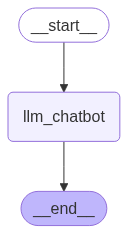

In [17]:
## Visualize the graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [18]:
response = graph.invoke({"messages":"Hi"})
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [19]:
for event in graph.stream({"messages": "Hi, How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?


### ChatBot with tool calls

In [20]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Paris',
   'title': 'Paris - Wikipedia',
   'content': 'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi),',
   'score': 0.86024034,
   'raw_content': None},
  {'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
   'title': 'Paris facts: the capital of France in history',
   'content': 'Paris, France   ## Paris facts: Paris, the **capital of France** Paris is the **capital of France**, Paris has 2.234 million inhabitants ## Paris facts: Paris history Republic, Paris has a rich 2000 year history. See details of Paris churches, including Notre ## Paris facts: Paris, a world city Paris is a world capital city of shopping french fashion brands. All of this turns Paris into a ## Paris facts: the capital of France in history Before

In [21]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [23]:
WEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")

def get_weather(city: str) -> str:
    """
    Fetches current weather metrics for a given city and returns them as a formatted string.

    Args:
        city (str): Name of the city to retrieve weather data for.

    Returns:
        str: Formatted weather details including temperature, wind speed, pressure, humidity, and description.
    """
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={WEATHER_API_KEY}&units=metric"
    res = requests.get(url)

    if res.status_code != 200:
        return f"Error fetching weather data for '{city}': {res.status_code}"

    try:
        data = res.json()
        temp = data['main']['temp']
        humidity = data['main']['humidity']
        pressure = data['main']['pressure']
        wind = data['wind']['speed']
        description = data['weather'][0]['description']

        return (
            f"Weather in {city.title()}:\n"
            f"Temperature: {temp}°C\n"
            f"Wind Speed: {wind} m/s\n"
            f"Pressure: {pressure} hPa\n"
            f"Humidity: {humidity}%\n"
            f"Description: {description}"
        )
    except KeyError:
        return "Error parsing weather data response."

In [24]:
city_name = "Lahore"
get_weather(city_name)

'Weather in Lahore:\nTemperature: 29.79°C\nWind Speed: 1.46 m/s\nPressure: 996 hPa\nHumidity: 68%\nDescription: scattered clouds'

In [25]:
tools = [tool, multiply, get_weather]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x76debeb885e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x76debe87dd50>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

In [26]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

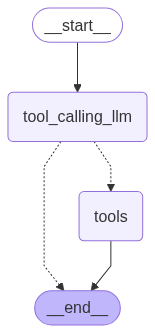

In [28]:
## Node defination

def tool_calling_llm(state: State) -> State:
    """Node that calls the LLM with tools"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]
            }

## Build the graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## add adges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", END)

graph = builder.compile()
## Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")


In [34]:
response = graph.invoke({"messages":"Give me the recent AI news then 5 multiply by 10?"})
response["messages"][-1].content

'50'

In [35]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news then 5 multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a17y6xv4j)
 Call ID: a17y6xv4j
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
  multiply (yf3mgxtmj)
 Call ID: yf3mgxtmj
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theguardian.com/technology/artificialintelligenceai", "title": "Artificial intelligence (AI) | The Guardian", "content": "## Artificial intelligence (AI)\n\n## 24 July 2025\n\nThe Google logo outside of its London office\n\n### AI summaries causing ‘devastating’ drop in online news audiences, study finds\n\n## 23 July 2025\n\nMan holds folder with scra

### ReactAgent

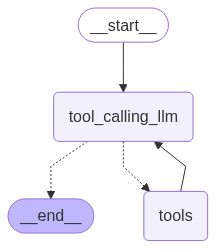

In [38]:

## Build the graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## add adges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", 'tool_calling_llm')

graph = builder.compile()
## Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [40]:
response = graph.invoke({"messages":"Give me the recent AI news and then 5 multiply by 10?"})
# response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then 5 multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (m1rr02g89)
 Call ID: m1rr02g89
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
  multiply (08d1z63q8)
 Call ID: 08d1z63q8
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.zdnet.com/article/ais-not-the-only-hot-tech-trend-check-out-the-years-other-11-according-to-mckinsey/", "title": "AI's not the only hot tech trend - check out the year's other ... - ZDNET", "content": "Recent innovations in AI have also been supercharging the field of robotics, including everything from self-driving cars to humanoid robots that can

### In  Memory savor it can also save memeory outside like postresql memory as well

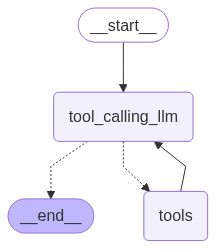

In [42]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()

## Build the graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## add adges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)

builder.add_edge("tools", 'tool_calling_llm')

graph = builder.compile(checkpointer=memory)
## Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [46]:
config = {"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"Have you remember my name?"}, config=config)
response["messages"][-1].content

'I remember your name as Saad Alam.'

### Streaming

In [47]:
def superbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

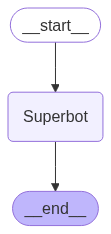

In [49]:
stream_builder = StateGraph(State)
stream_builder.add_node("Superbot", superbot)

stream_builder.add_edge(START, "Superbot")
stream_builder.add_edge("Superbot", END)


stream_graph = stream_builder.compile(checkpointer=memory)

## Visualize the graph
from IPython.display import Image, display
try:
    display(Image(stream_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")




In [52]:
config = {"configurable":{"thread_id": "2"}}

response = stream_graph.invoke({"messages": "This is Saad Alam, and i want to get the configuration paramters of UNET Architecture in biomedical imaging."}, config=config)
response["messages"][-1].content

"Nice to meet you, Saad!\n\nUNET (U-Net) is a popular deep learning architecture used in biomedical imaging for tasks such as image segmentation, classification, and denoising. The configuration parameters of a UNET architecture can vary depending on the specific application, dataset, and performance requirements. Here are some common configuration parameters used in biomedical imaging:\n\n**Encoder (Contracting Path)**\n\n1. **Number of Convolutional Layers**: 4-6 layers\n2. **Filter Size**: 3x3 or 5x5\n3. **Number of Filters**: 32-256\n4. **Stride**: 2 (max pooling)\n5. **Activation Function**: ReLU (Rectified Linear Unit)\n\n**Decoder (Expansive Path)**\n\n1. **Number of Convolutional Layers**: 4-6 layers\n2. **Filter Size**: 3x3 or 5x5\n3. **Number of Filters**: Same as encoder\n4. **Upsampling Method**: UpSampling2D or Conv2DTranspose\n5. **Activation Function**: ReLU (Rectified Linear Unit)\n\n**Output Layer**\n\n1. **Number of Filters**: 1 (for binary segmentation) or number of 

### Streaming
- Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

- values : This streams the full state of the graph after each node is called.
- updates : This streams updates to the state of the graph after each node is called.

In [57]:

response = stream_graph.invoke({"messages": "This is Saad Alam, and i want to get the configuration paramters of UNET Architecture in biomedical imaging."}, config=config, stream_mode="updates")
response

[{'Superbot': {'messages': [AIMessage(content="Here are some common configuration parameters for UNET architecture in biomedical imaging:\n\n**Encoder (Contracting Path)**\n\n1. **Number of Convolutional Layers**: 4-6 layers\n2. **Filter Size**: 3x3 or 5x5\n3. **Number of Filters**: 32-256\n4. **Stride**: 2 (max pooling)\n5. **Activation Function**: ReLU (Rectified Linear Unit)\n\n**Decoder (Expansive Path)**\n\n1. **Number of Convolutional Layers**: 4-6 layers\n2. **Filter Size**: 3x3 or 5x5\n3. **Number of Filters**: Same as encoder\n4. **Upsampling Method**: UpSampling2D or Conv2DTranspose\n5. **Activation Function**: ReLU (Rectified Linear Unit)\n\n**Output Layer**\n\n1. **Number of Filters**: 1 (for binary segmentation) or number of classes (for multiclass segmentation)\n2. **Activation Function**: Sigmoid (for binary segmentation) or softmax (for multiclass segmentation)\n\n**Other Parameters**\n\n1. **Batch Normalization**: Yes, applied to the convolutional layers\n2. **Dropout*

In [59]:

response = stream_graph.invoke({"messages": "This is Saad Alam, and i want to get the configuration paramters of UNET Architecture in biomedical imaging."}, config=config, stream_mode="values")
response

{'messages': [HumanMessage(content='This is Saad Alam, and i want to get the configuration paramters of UNET Architecture in biomedical imaging.', additional_kwargs={}, response_metadata={}, id='018922e7-e8e0-41e1-8809-fd656aa0891b'),
  AIMessage(content="Nice to meet you, Saad!\n\nUNET (U-Net) is a popular deep learning architecture used in biomedical imaging for tasks such as image segmentation, classification, and denoising. The configuration parameters of a UNET architecture can vary depending on the specific application, dataset, and performance requirements. However, I can provide you with a general overview of the common configuration parameters used in biomedical imaging:\n\n1. **Network Architecture:**\n\t* Encoder (Contracting Path): Typically consists of convolutional layers (Conv2D) with a stride of 2, followed by max pooling layers (MaxPooling2D).\n\t* Decoder (Expansive Path): Typically consists of convolutional layers (Conv2D) with a stride of 2, followed by upsampling l

In [ ]:
response = stream_graph.invoke({"messages": "This is Saad Alam, and i want to get the configuration paramters of UNET Architecture in biomedical imaging."}, config=config, stream_mode="values")
response

<generator object Pregel.stream at 0x76deabb6c120>